<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scripts/JJ_Quantum_Tunneling_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import pandas as pd

In [ ]:
# Onri prefers using rcParams to increase the quality of all plots to be higher than the default settings.
# This only needs to be done once at beginning of every Jupyter Notebook.
plt.rcParams['figure.dpi'] = 200

# High contrast plotting style via rcParams
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.facecolor'] = '#000000'
plt.rcParams['axes.facecolor'] = '#000000'
plt.rcParams['axes.edgecolor'] = '#FFFFFF'
plt.rcParams['axes.labelcolor'] = '#FFFFFF'
plt.rcParams['xtick.color'] = '#FFFFFF'
plt.rcParams['ytick.color'] = '#FFFFFF'
plt.rcParams['text.color'] = '#FFFFFF'
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['grid.color'] = '#444444'

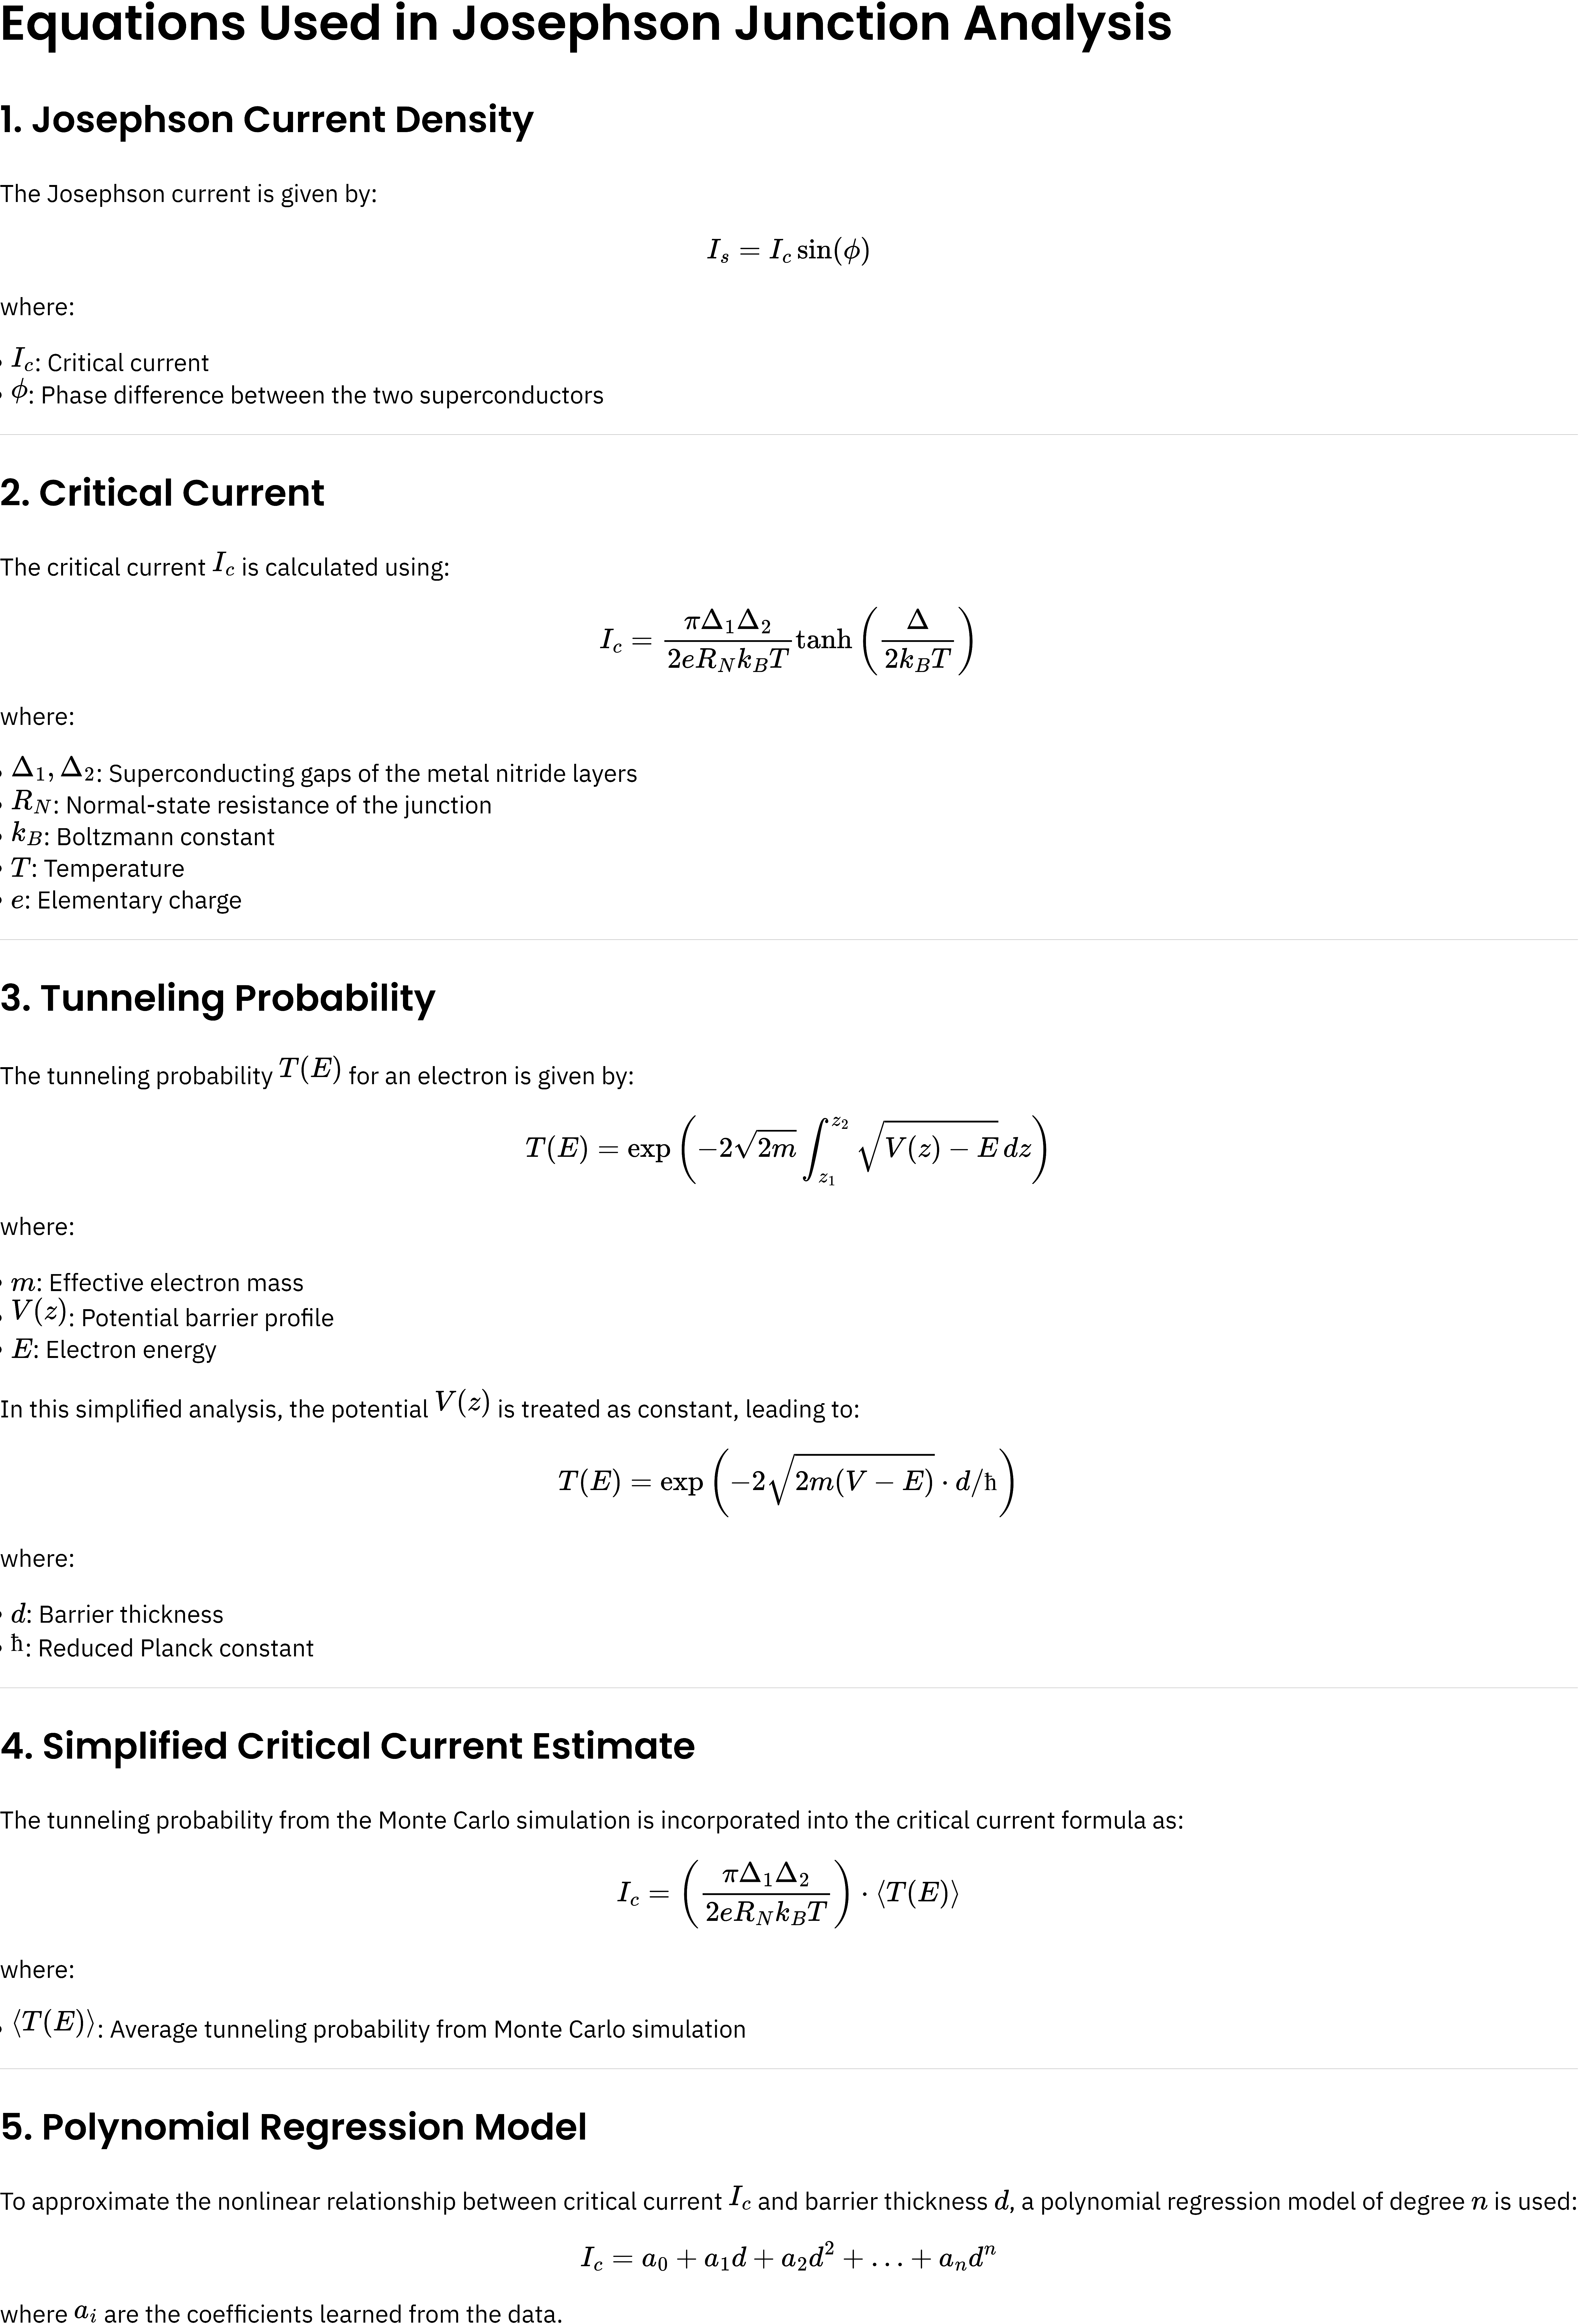

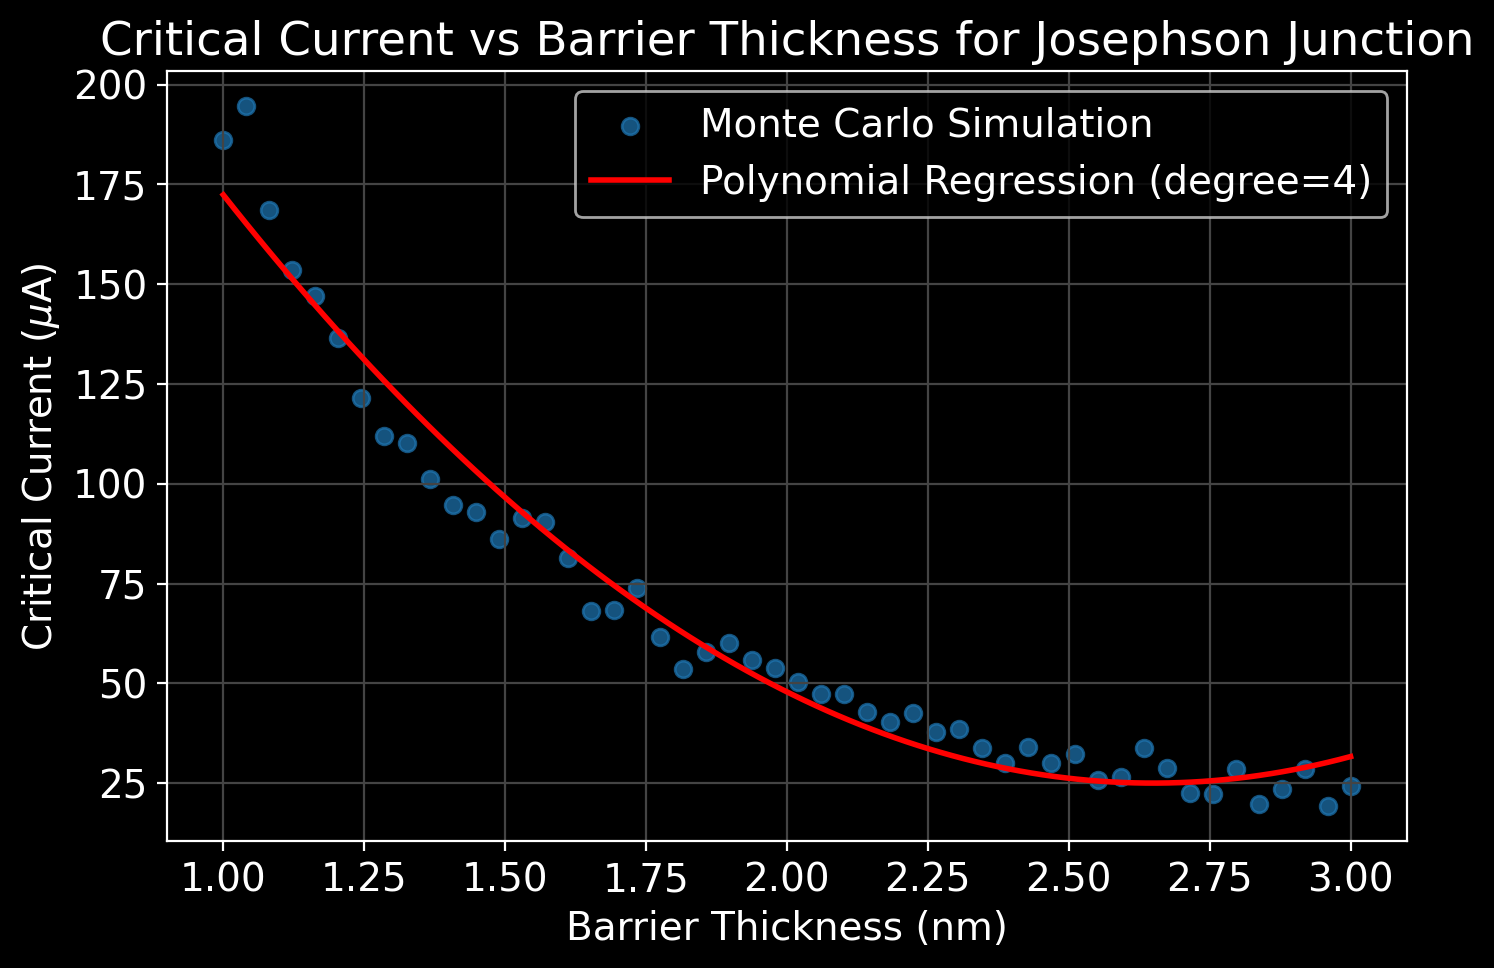

   Barrier Thickness (nm)  Critical Current (uA)
0                1.000000             186.115933
1                1.040816             194.534330
2                1.081633             168.540763
3                1.122449             153.529045
4                1.163265             147.140062


In [ ]:
# Constants
e = 1.602e-19  # Charge of electron (Coulombs)
k_B = 1.381e-23  # Boltzmann constant (J/K)
hbar = 1.054e-34  # Reduced Planck's constant (Js)
m_e = 9.109e-31  # Electron mass (kg)
T_fixed = 4.2  # Temperature (K), typical for LN2 cooling
V_barrier = 1.5e-19  # Barrier height (J), typical for AlN
d_values = np.linspace(1e-9, 3e-9, 50)  # Barrier thickness range (m)
Delta1, Delta2 = 1.5e-3 * e, 1.5e-3 * e  # Superconducting gap (J)
R_N = 1.0  # Normal resistance (Ohms)

# Monte Carlo Simulation for tunneling probability
def tunneling_probability(V, E, d, m=m_e):
    """Calculates tunneling probability for an electron."""
    if E >= V:
        return 1  # No barrier
    return np.exp(-2 * np.sqrt(2 * m) * np.sqrt(V - E) * d / hbar)

# Simulate tunneling and critical current
np.random.seed(42)
n_samples = 10000
data = []  # To store generated dataset
for d in d_values:
    # Monte Carlo sampling for electron energy
    energies = np.random.uniform(0, V_barrier, n_samples)
    probabilities = [tunneling_probability(V_barrier, E, d) for E in energies]
    average_tunneling_prob = np.mean(probabilities)
    # Calculate critical current using the simplified tunneling formula
    Ic = (np.pi * Delta1 * Delta2 / (2 * e * R_N * k_B * T_fixed)) * average_tunneling_prob
    data.append([d, T_fixed, Delta1, Delta2, R_N, Ic])

# Convert to NumPy array for machine learning
data = np.array(data)
d_values, Ic_values = data[:, 0], data[:, -1]

# Polynomial Regression Model
X = d_values.reshape(-1, 1)  # Use only thickness as a feature for simplicity
y = Ic_values
degree = 4 # Polynomial degree
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)

# Predictions using the trained model
d_test = np.linspace(1e-9, 3e-9, 100).reshape(-1, 1)
Ic_pred = model.predict(d_test)

# Visualize results
plt.figure(figsize=(8, 5))
plt.scatter(d_values * 1e9, Ic_values * 1e6, label="Monte Carlo Simulation", alpha=0.7)
plt.plot(d_test.flatten() * 1e9, Ic_pred * 1e6, label=f"Polynomial Regression (degree={degree})", color="red")
plt.xlabel("Barrier Thickness (nm)")
plt.ylabel("Critical Current ($\mu$A)")
plt.title("Critical Current vs Barrier Thickness for Josephson Junction")
plt.legend()
plt.grid()
plt.show()

# Present data as a pandas DataFrame
results_df = pd.DataFrame({
    "Barrier Thickness (nm)": d_values * 1e9,
    "Critical Current (uA)": Ic_values * 1e6
})

# Print the DataFrame
print(results_df.head())  # Display first few rows
